In [1]:
!pip install googlenet-pytorch

In [1]:
from googlenet_pytorch import GoogLeNet 
model = GoogLeNet.from_pretrained('googlenet')

Loaded pretrained weights for googlenet


In [2]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import pandas as pd
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [4]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 
#SIZE = 256  #Resize images
SIZE = 224  #Resize images

for directory_path in glob.glob("D:/rice/output/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        #img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(len(train_images))
print(len(train_labels))

BrownSpot
Healthy
Hispa
LeafBlast
1060
1060


In [5]:
print(len(train_images))
print(len(train_labels))

1060
1060


In [6]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("D:/rice/output/val/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(len(test_images))
print(len(test_labels))

280
280


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

In [8]:
x_train.shape[0]

1060

In [9]:
#p = x_train.reshape(2248,3,224,224)
p = x_train.reshape(x_train.shape[0],3,224,224)

In [10]:
print(p.shape)

(1060, 3, 224, 224)


In [11]:
import torch
tensor_x = torch.from_numpy(np.array(p)).float()
print(tensor_x.shape)

torch.Size([1060, 3, 224, 224])


In [12]:
features = model.extract_features(tensor_x)

In [13]:
print(features.shape)

torch.Size([1060, 1024, 7, 7])


In [14]:
X_for_RF = features.detach().numpy()
#print(x[0])
print(X_for_RF.shape)
print(type(X_for_RF))

(1060, 1024, 7, 7)
<class 'numpy.ndarray'>


In [15]:
features = X_for_RF.reshape(X_for_RF.shape[0], -1)

X_for_RF = features #This is our X input to RF
print(X_for_RF.shape)
print(type(X_for_RF))

(1060, 50176)
<class 'numpy.ndarray'>


In [16]:
from sklearn.ensemble import RandomForestClassifier
import time
RF_model = RandomForestClassifier(n_estimators=300, max_depth=60, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding


RandomForestClassifier(max_depth=60, n_estimators=300, random_state=42)

In [17]:
print(x_test.shape)

(280, 224, 224, 3)


In [18]:
#p = x_train.reshape(2248,3,224,224)
x_test = x_test.reshape(x_test.shape[0],3,224,224)

In [19]:
print(x_test.shape)

(280, 3, 224, 224)


In [20]:
import torch
x_test = torch.from_numpy(np.array(x_test)).float()
print(x_test.shape)

torch.Size([280, 3, 224, 224])


In [21]:
x_test_features = model.extract_features(x_test)

In [22]:
x_test_features = x_test_features.detach().numpy()
print(x_test_features.shape)

(280, 1024, 7, 7)


In [23]:
x_test_features = x_test_features.reshape(x_test_features.shape[0], -1)
print(x_test_features.shape)

(280, 50176)


In [24]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(x_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

Accuracy =  0.44285714285714284
              precision    recall  f1-score   support

   BrownSpot       0.61      0.66      0.63        70
     Healthy       0.34      0.41      0.37        70
       Hispa       0.39      0.34      0.36        70
   LeafBlast       0.44      0.36      0.39        70

    accuracy                           0.44       280
   macro avg       0.44      0.44      0.44       280
weighted avg       0.44      0.44      0.44       280

[[46 13  4  7]
 [ 8 29 23 10]
 [ 9 22 24 15]
 [13 21 11 25]]


<AxesSubplot:>

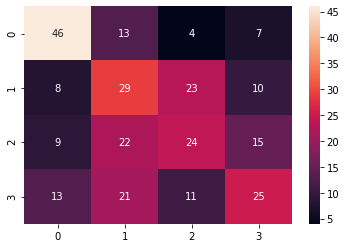

In [26]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(test_labels, prediction_RF)

print(classification_report(test_labels, prediction_RF))

print(cm)
sns.heatmap(cm, annot=True)